In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
kaggle_credentails = json.load(open("/content/kaggle.json"))

In [ ]:
# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [ ]:
!kaggle datasets download -d kaustubhb999/tomatoleaf

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
 92% 164M/179M [00:01<00:00, 114MB/s]
100% 179M/179M [00:01<00:00, 101MB/s]


In [ ]:
# Unzip the downloaded dataset
with ZipFile("tomatoleaf.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import os

# Define the base directory for your dataset
base_dir = "tomato"

# Define the directories for training
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

# Function to count the number of items in each class folder
def count_classes(directory):
    class_counts = {}
    class_names = os.listdir(directory)  # List all class folders
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            num_items = len(os.listdir(class_path))  # Count files in the class folder
            class_counts[class_name] = num_items
    return class_counts

# Count classes in the training and validation directories
train_class_counts = count_classes(train_dir)
val_class_counts = count_classes(val_dir)

# Print number of classes and items in each class
print("Training Class Counts:")
print(train_class_counts)
print("Validation Class Counts:")
print(val_class_counts)

# Total number of classes
total_classes = len(train_class_counts)
print(f"\nTotal Number of Classes: {total_classes}")


Training Class Counts:
{'Tomato___Septoria_leaf_spot': 1000, 'Tomato___Tomato_mosaic_virus': 1000, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 1000, 'Tomato___Late_blight': 1000, 'Tomato___Target_Spot': 1000, 'Tomato___Leaf_Mold': 1000, 'Tomato___Spider_mites Two-spotted_spider_mite': 1000, 'Tomato___Early_blight': 1000, 'Tomato___Bacterial_spot': 1000, 'Tomato___healthy': 1000}
Validation Class Counts:
{'Tomato___Septoria_leaf_spot': 100, 'Tomato___Tomato_mosaic_virus': 100, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 100, 'Tomato___Late_blight': 100, 'Tomato___Target_Spot': 100, 'Tomato___Leaf_Mold': 100, 'Tomato___Spider_mites Two-spotted_spider_mite': 100, 'Tomato___Early_blight': 100, 'Tomato___Bacterial_spot': 100, 'Tomato___healthy': 100}

Total Number of Classes: 10


In [ ]:
# Load dataset using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Adjust the size to match your model's expected input size
    batch_size=32,
    label_mode='categorical'  # Assuming you have multiple classes
)
# Load validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),  # Resizing during loading
    batch_size=32,
    label_mode='categorical'  # Assuming you have multiple classes
)
# Extract class names from the dataset
class_names = train_dataset.class_names

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


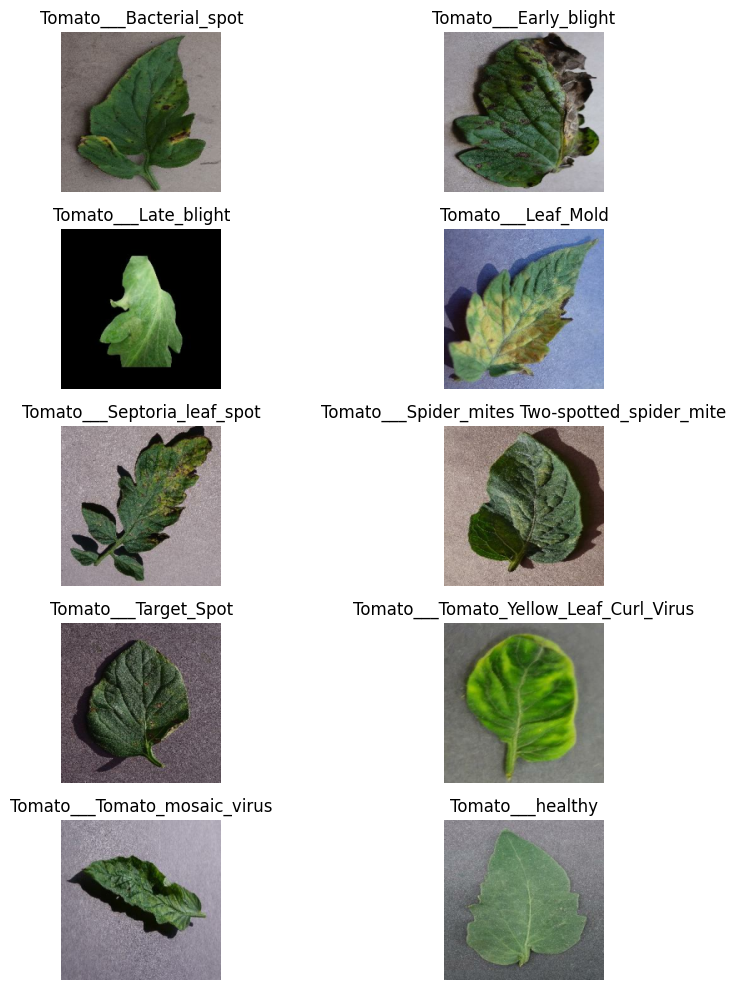

In [ ]:
import matplotlib.pyplot as plt

# Function to display an image from each class
def display_images_from_each_class(dataset, class_names):
    plt.figure(figsize=(10, 10))
    displayed_classes = set()  # To track displayed classes

    for images, labels in dataset:
        for i in range(len(class_names)):
            # Check if this class has already been displayed
            if i not in displayed_classes and labels[0][i].numpy() == 1:  # Access the first image and check the label
                plt.subplot(5, 2, i + 1)
                plt.imshow(images[0].numpy().astype("uint8"))  # Display the first image
                plt.title(class_names[i])
                plt.axis("off")
                displayed_classes.add(i)  # Add this class to displayed_classes

            # Stop if all classes have been displayed
            if len(displayed_classes) == len(class_names):
                break
        if len(displayed_classes) == len(class_names):
            break  # Exit the outer loop as well

    plt.tight_layout()
    plt.show()

# Display one image from each class before pre-processing
display_images_from_each_class(train_dataset, class_names)


##Data Generators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Data augmentation for training and rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # No shuffle for validation
)

print("Data generators created.")


Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Data generators created.



## Model Setup and Training - EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Define EfficientNetB0 model
def build_efficientnetb0(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers initially

    # Custom layers
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='swish', kernel_regularizer=l2(1e-4))(x)  # Swish activation with L2 regularization
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [ ]:
from tensorflow.keras.optimizers import Adam

# Build and compile EfficientNetB0
efficientnetb0_model = build_efficientnetb0(input_shape=(224, 224, 3), num_classes=len(class_names))
efficientnetb0_model.compile(optimizer=Adam(learning_rate=0.001),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Summary of the model
efficientnetb0_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,219,949 (16.10 MB)

 Trainable params: 167,818 (655.54 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
# Train EfficientNetB0
efficientnetb0_history = efficientnetb0_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 185s 505ms/step - accuracy: 0.0989 - loss: 2.4460 - val_accuracy: 0.1000 - val_loss: 2.3272 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 157s 402ms/step - accuracy: 0.1005 - loss: 2.3723 - val_accuracy: 0.1000 - val_loss: 2.3267 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 392ms/step - accuracy: 0.1005 - loss: 2.3484 - val_accuracy: 0.1000 - val_loss: 2.3268 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 398ms/step - accuracy: 0.0993 - loss: 2.3424 - val_accuracy: 0.1000 - val_loss: 2.3262 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 392ms/step - accuracy: 0.0992 - loss: 2.3386 - val_accuracy: 0.1000 - val_loss: 2.3266 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 391ms/step - accuracy: 0.1038 - loss: 2.3334 - val_accuracy: 0.1000 - val_loss: 2.3275 - learning_rate: 0.0010
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 397ms/step - accuracy: 0.1062 

In [ ]:
# Fine-tuning EfficientNetB0
efficientnetb0_model.layers[1].trainable = True  # Unfreeze the base model layers
efficientnetb0_model.compile(optimizer=Adam(learning_rate=1e-4),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

fine_tune_history = efficientnetb0_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 265s 593ms/step - accuracy: 0.3866 - loss: 1.7510 - val_accuracy: 0.1000 - val_loss: 2.6539 - learning_rate: 1.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 165s 422ms/step - accuracy: 0.9206 - loss: 0.3097 - val_accuracy: 0.3120 - val_loss: 2.6067 - learning_rate: 1.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 430ms/step - accuracy: 0.9656 - loss: 0.1224 - val_accuracy: 0.9420 - val_loss: 0.2013 - learning_rate: 1.0000e-04
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 133s 419ms/step - accuracy: 0.9739 - loss: 0.0928 - val_accuracy: 0.9770 - val_loss: 0.0967 - learning_rate: 1.0000e-04
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 147s 435ms/step - accuracy: 0.9830 - loss: 0.0626 - val_accuracy: 0.9780 - val_loss: 0.0779 - learning_rate: 1.0000e-04
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 419ms/step - accuracy: 0.9856 - loss: 0.0550 - val_accuracy: 0.9740 - val_loss: 0.1079 - learning_rate: 1.0000e-04
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Extract class names from the original train dataset
class_names = train_dataset.class_names
print(class_names)


['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


## Save Model and Visualize Training

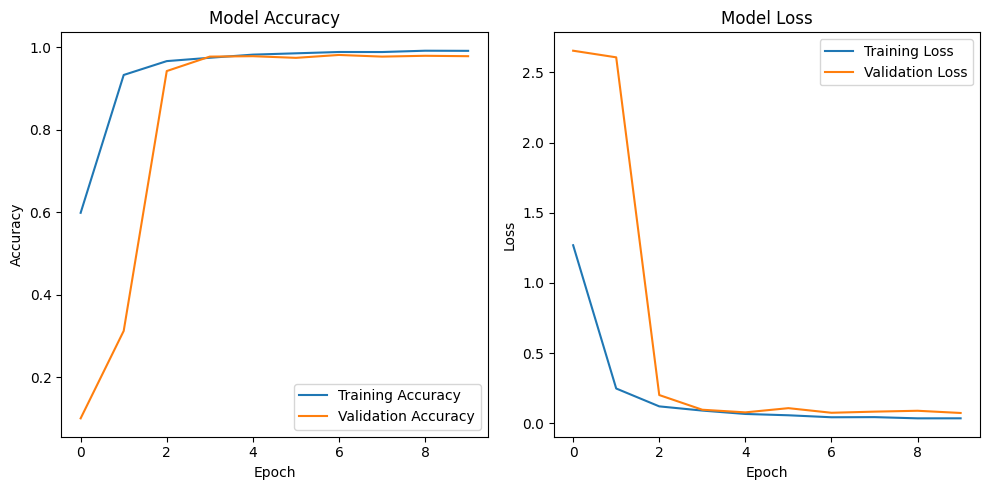

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from model.fit()
# Replace 'history' with the variable storing your training history


# Extracting values for accuracy and loss
accuracy = fine_tune_history.history['accuracy']
val_accuracy = fine_tune_history.history['val_accuracy']
loss = fine_tune_history.history['loss']
val_loss = fine_tune_history.history['val_loss']
epochs = range(len(accuracy))

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Image: Tomato___Tomato_Yellow_Leaf_Curl_Virus.png
Actual Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Predicted Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Confidence: 100.00%


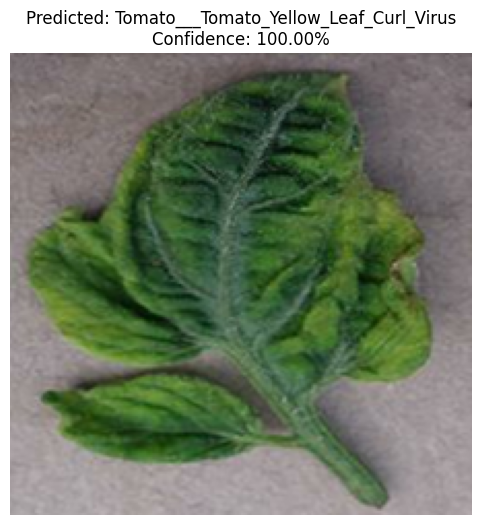

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: Tomato___Tomato_mosaic_virus.png
Actual Class: Tomato___Tomato_mosaic_virus
Predicted Class: Tomato___Tomato_mosaic_virus
Confidence: 100.00%


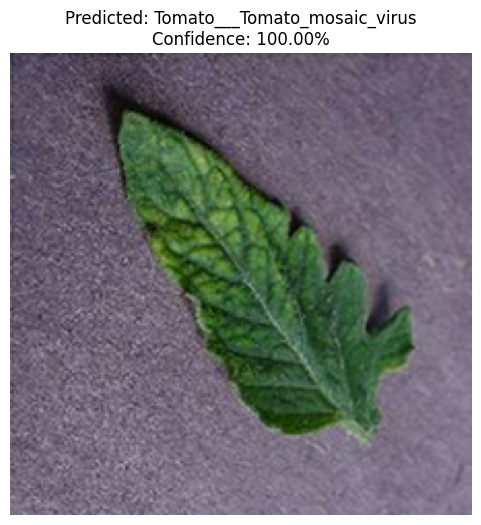

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: Tomato___Septoria_leaf_spot.png
Actual Class: Tomato___Septoria_leaf_spot
Predicted Class: Tomato___Septoria_leaf_spot
Confidence: 99.99%


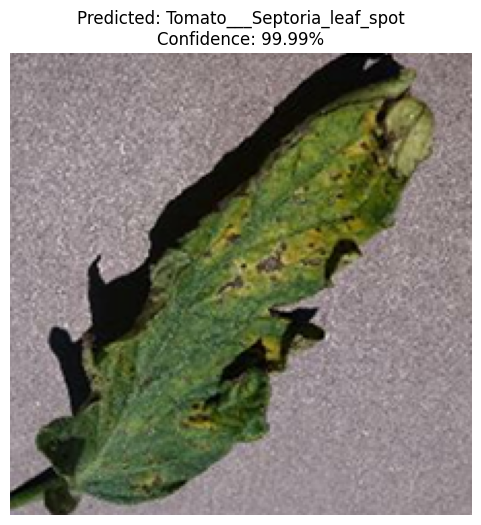

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: Tomato___Late_blight.png
Actual Class: Tomato___Late_blight
Predicted Class: Tomato___Septoria_leaf_spot
Confidence: 56.15%


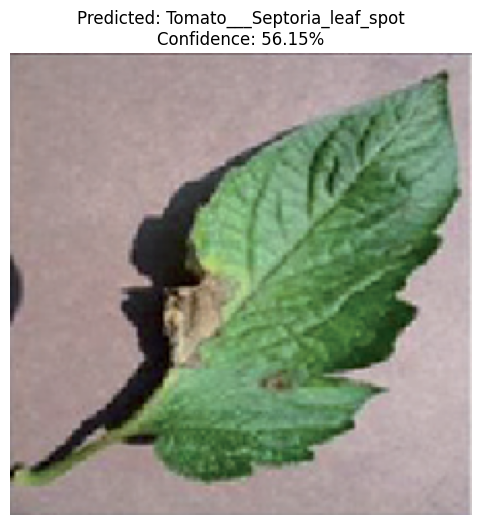

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: Tomato___Leaf_Mold.png
Actual Class: Tomato___Leaf_Mold
Predicted Class: Tomato___Leaf_Mold
Confidence: 99.98%


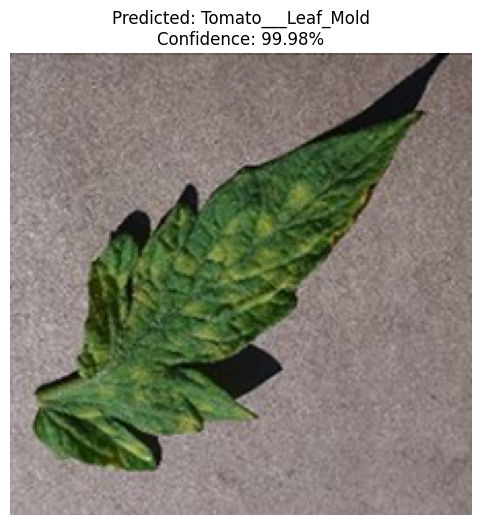

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: Tomato___Bacterial_spot.png
Actual Class: Tomato___Bacterial_spot
Predicted Class: Tomato___Bacterial_spot
Confidence: 99.97%


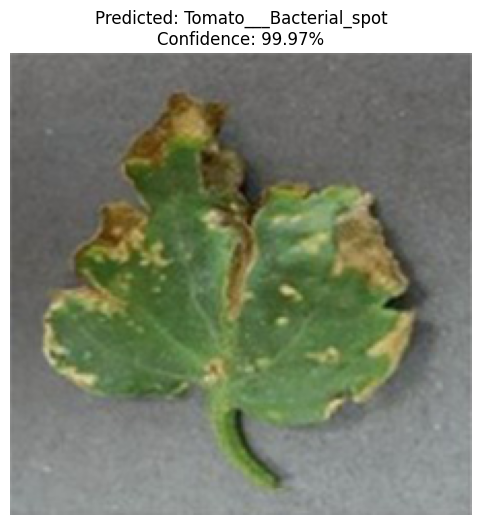

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

test_images_dir = "/content/drive/MyDrive/ML_Project/test images"  # Your folder with test images


# Function to preprocess and predict an image
def preprocess_and_predict(img_path):
    # Load the image with target size (224, 224)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale image

    # Predict the class
    predictions = efficientnetb0_model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=1)
    predicted_class = class_names[predicted_class_idx[0]]
    confidence = np.max(predictions) * 100  # Confidence as percentage

    return predicted_class, confidence, img

# Loop through each image in the test folder and make predictions
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

for img_file in test_images:
    img_path = os.path.join(test_images_dir, img_file)

    # Actual class is the image filename (before the extension)
    actual_class = img_file.split('.')[0]

    # Get prediction results
    predicted_class, confidence, img = preprocess_and_predict(img_path)

    # Print results
    print(f"Image: {img_file}")
    print(f"Actual Class: {actual_class}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")

    # Display image with results
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()


In [ ]:
efficientnetb0_model.save("efficientnetb0_model.h5")


## Model Setup and Training - MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.regularizers import l2

def build_mobilenetv2(input_shape, num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers initially

    # Custom layers
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)  # Regularization added
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [ ]:
from tensorflow.keras.optimizers import Adam


# Build and compile MobileNetV2
mobilenetv2_model = build_mobilenetv2(input_shape=(224, 224, 3), num_classes=len(class_names))
mobilenetv2_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
mobilenetv2_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,428,362 (9.26 MB)

 Trainable params: 167,818 (655.54 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
# Train MobileNetV2 with class weights
mobilenetv2_history = mobilenetv2_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 424ms/step - accuracy: 0.5624 - loss: 1.3925 - val_accuracy: 0.7740 - val_loss: 0.6774 - learning_rate: 0.0010
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 125s 393ms/step - accuracy: 0.7578 - loss: 0.7329 - val_accuracy: 0.7890 - val_loss: 0.6472 - learning_rate: 0.0010
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 389ms/step - accuracy: 0.7934 - loss: 0.6377 - val_accuracy: 0.8140 - val_loss: 0.5654 - learning_rate: 0.0010
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 388ms/step - accuracy: 0.8060 - loss: 0.5851 - val_accuracy: 0.8230 - val_loss: 0.6039 - learning_rate: 0.0010
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 388ms/step - accuracy: 0.8160 - loss: 0.5557 - val_accuracy: 0.8330 - val_loss: 0.5898 - learning_rate: 0.0010
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 388ms/step - accuracy: 0.8218 - loss: 0.5468 - val_accuracy: 0.8250 - val_loss: 0.6014 - learning_rate: 0.0010
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 388ms/step - accuracy: 0.8324 

In [ ]:
# Fine-tune the model
mobilenetv2_model.layers[1].trainable = True  # Unfreeze base layers
mobilenetv2_model.compile(optimizer=Adam(learning_rate=1e-4),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

fine_tune_history = mobilenetv2_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 204s 491ms/step - accuracy: 0.7646 - loss: 0.7818 - val_accuracy: 0.6050 - val_loss: 2.0867 - learning_rate: 1.0000e-04
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 154s 412ms/step - accuracy: 0.9188 - loss: 0.2725 - val_accuracy: 0.6690 - val_loss: 1.4337 - learning_rate: 1.0000e-04
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 133s 413ms/step - accuracy: 0.9461 - loss: 0.1894 - val_accuracy: 0.6620 - val_loss: 1.3985 - learning_rate: 1.0000e-04
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 409ms/step - accuracy: 0.9649 - loss: 0.1407 - val_accuracy: 0.7720 - val_loss: 0.9919 - learning_rate: 1.0000e-04
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 131s 410ms/step - accuracy: 0.9700 - loss: 0.1241 - val_accuracy: 0.6530 - val_loss: 1.7168 - learning_rate: 1.0000e-04


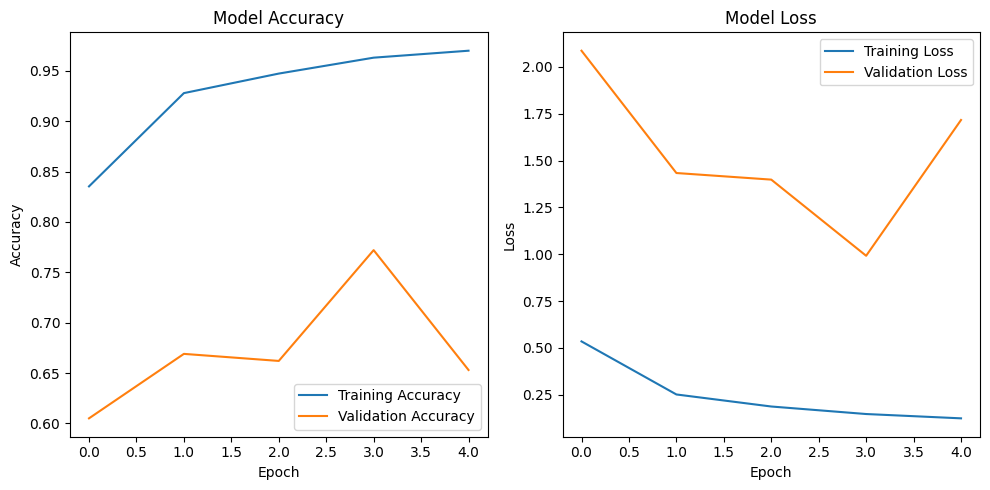

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from model.fit()
# Replace 'history' with the variable storing your training history


# Extracting values for accuracy and loss
accuracy = fine_tune_history.history['accuracy']
val_accuracy = fine_tune_history.history['val_accuracy']
loss = fine_tune_history.history['loss']
val_loss = fine_tune_history.history['val_loss']
epochs = range(len(accuracy))

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image: Tomato___Bacterial_spot.png
Actual Class: Tomato___Bacterial_spot
Predicted Class: Tomato___healthy
Confidence: 33.46%


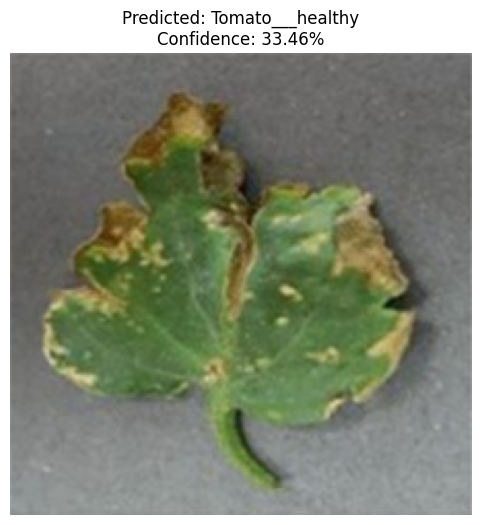

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: Tomato___Tomato_mosaic_virus.png
Actual Class: Tomato___Tomato_mosaic_virus
Predicted Class: Tomato___Tomato_mosaic_virus
Confidence: 100.00%


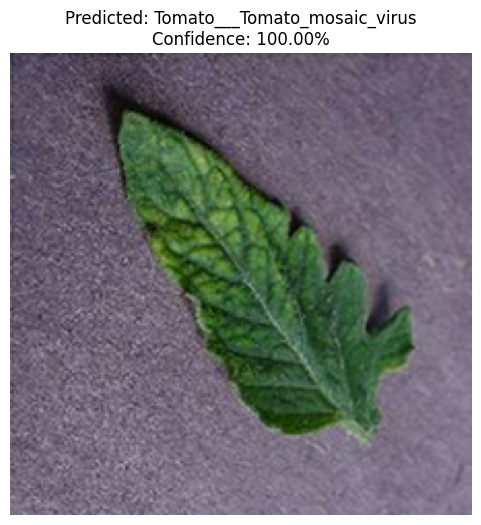

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: Tomato___Septoria_leaf_spot.png
Actual Class: Tomato___Septoria_leaf_spot
Predicted Class: Tomato___Tomato_mosaic_virus
Confidence: 74.40%


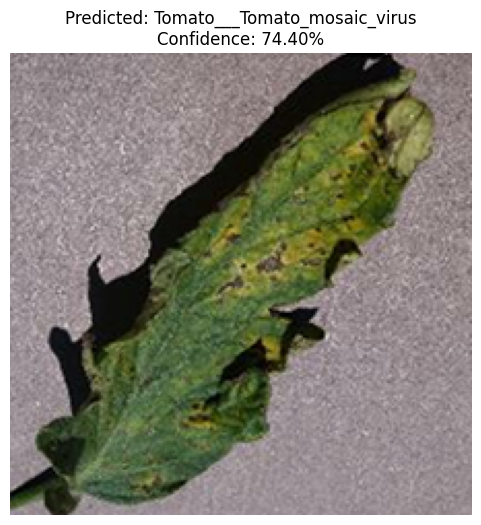

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: Tomato___Tomato_Yellow_Leaf_Curl_Virus.png
Actual Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Predicted Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Confidence: 100.00%


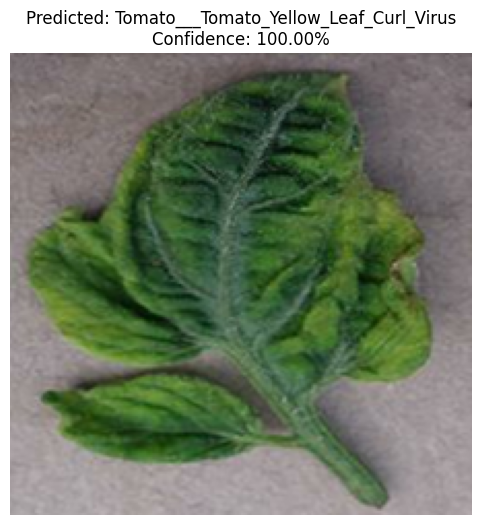

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: Tomato___Late_blight.png
Actual Class: Tomato___Late_blight
Predicted Class: Tomato___Leaf_Mold
Confidence: 97.22%


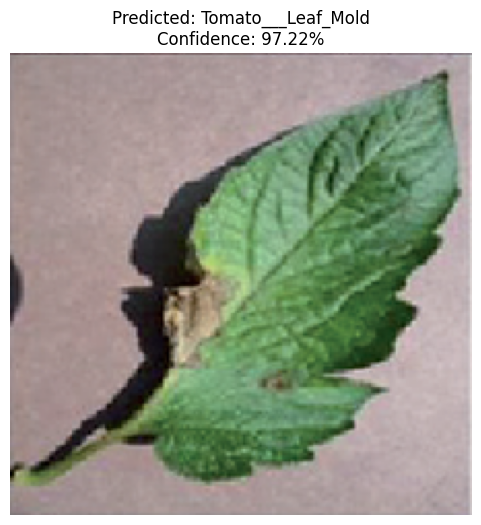

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image: Tomato___Leaf_Mold.png
Actual Class: Tomato___Leaf_Mold
Predicted Class: Tomato___Tomato_mosaic_virus
Confidence: 83.83%


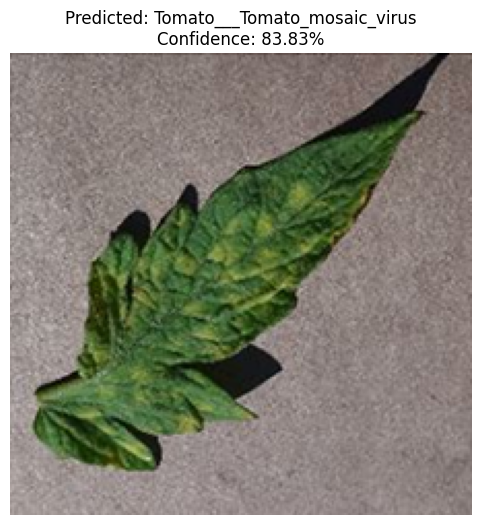

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

test_images_dir = "/content/drive/MyDrive/VOD/test images"  # Your folder with test images


# Function to preprocess and predict an image
def preprocess_and_predict(img_path):
    # Load the image with target size (224, 224)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale image

    # Predict the class
    predictions = mobilenetv2_model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=1)
    predicted_class = class_names[predicted_class_idx[0]]
    confidence = np.max(predictions) * 100  # Confidence as percentage

    return predicted_class, confidence, img

# Loop through each image in the test folder and make predictions
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

for img_file in test_images:
    img_path = os.path.join(test_images_dir, img_file)

    # Actual class is the image filename (before the extension)
    actual_class = img_file.split('.')[0]

    # Get prediction results
    predicted_class, confidence, img = preprocess_and_predict(img_path)

    # Print results
    print(f"Image: {img_file}")
    print(f"Actual Class: {actual_class}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")

    # Display image with results
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()


In [ ]:
mobilenetv2_model.save("mobilenetv2_model.h5")